## 데이터 초기화 

※필수 실행!!※

In [ ]:
# 환율 예측
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

In [ ]:
currency = pd.read_csv('/content/drive/MyDrive/2022/data/USD_KRW 내역.csv', thousands=',')
currency

In [ ]:
currency = currency.drop(axis=1, columns='거래량')

In [ ]:
for i in range(len(currency)):
  currency['변동 %'][i] = currency['변동 %'][i].replace('%','')
currency

In [ ]:
# for i in range(len(currency)):
#   currency['날짜'][i] = currency['날짜'][i].replace('- ','')
# currency

In [ ]:
currency.info()

In [ ]:
currency

In [ ]:
# plt.figure(figsize=(200, 100))
# plt.plot(currency['날짜'], currency['종가'])

In [ ]:
currency['날짜'] = currency['날짜'].astype('datetime64')

In [ ]:
currency['변동 %'] = currency['변동 %'].astype('float64')

In [ ]:
currency.info()

## LinearRegression을 이용한 시도

In [ ]:
from sklearn.linear_model import LinearRegression
x = np.array(currency['날짜'])
y = currency['종가']
model = LinearRegression()
model.fit(x.reshape(-1,1), y)

In [ ]:
plt.figure(figsize=(15,17))
plt.title("price index")
plt.plot(currency['날짜'], currency['종가'])
# plt.plot(x, model.predict(x.reshape(-1,1)), 'r')
plt.xlabel('year')
plt.ylabel('price')
plt.show()

In [ ]:
y = model.predict([[20221031]])
print('예상 USD to KRW 값은 ', y, '원입니다.')

### 결과

- 입력을 진행했을 때 결과는 나오지만, 확인을 해보니 데이터를 제대로 학습하지 못하고 결과를 도출한 것으로 확인됨. 

- 데이터가 제대로 학습된다고 해도 환율 변동에 굴곡이 없고 상승 예측만 하는 것으로 확인됨. 

결론: LinearRegression 하나로는 환율 예측에 부적합하다.

## LSTM 모델 시도

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['종가', '오픈', '고가', '저가', '변동 %']
scaled = scaler.fit_transform(currency[scale_cols])
scaled

array([[0.60004479, 0.58293349, 0.58151454, 0.61293117, 0.47704685],
       [0.60577741, 0.61035771, 0.61235243, 0.62095901, 0.42262186],
       [0.63427633, 0.63262462, 0.63010366, 0.65501933, 0.43587317],
       ...,
       [0.42502053, 0.41473926, 0.41174777, 0.44238206, 0.46474207],
       [0.43479884, 0.42127568, 0.42060179, 0.45220418, 0.4789399 ],
       [0.43927745, 0.4198391 , 0.42175353, 0.45406032, 0.50070989]])

In [ ]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('종가', 1), df['종가'], test_size=0.2, random_state=0, shuffle=False)

In [ ]:
x_train

오픈        고가        저가      변동 %
0     0.582933  0.581515  0.612931  0.477047
1     0.610358  0.612352  0.620959  0.422622
2     0.632625  0.630104  0.655019  0.435873
3     0.624565  0.630910  0.665429  0.511595
4     0.611320  0.626548  0.649822  0.522953
...        ...       ...       ...       ...
3943  0.024925  0.020227  0.026837  0.497397
3944  0.021118  0.017780  0.023047  0.480833
3945  0.023847  0.020731  0.027688  0.486512
3946  0.024134  0.022171  0.027224  0.495977
3947  0.023344  0.022099  0.026837  0.492191

[3948 rows x 4 columns]

In [ ]:
import tensorflow as tf

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [ ]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os


model = Sequential([
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [ ]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    120/Unknown - 5s 13ms/step - loss: 0.0064 - mse: 0.0127
Epoch 1: val_loss improved from inf to 0.00038, saving model to tmp/ckeckpointer.ckpt
123/123 [==============================] - 6s 24ms/step - loss: 0.0063 - mse: 0.0125 - val_loss: 3.7580e-04 - val_mse: 7.5161e-04
Epoch 2/50
122/123 [============================>.] - ETA: 0s - loss: 4.1509e-04 - mse: 8.3018e-04
Epoch 2: val_loss improved from 0.00038 to 0.00011, saving model to tmp/ckeckpointer.ckpt
123/123 [==============================] - 2s 16ms/step - loss: 4.2128e-04 - mse: 8.4255e-04 - val_loss: 1.1104e-04 - val_mse: 2.2208e-04
Epoch 3/50
119/123 [============================>.] - ETA: 0s - loss: 3.6044e-04 - mse: 7.2087e-04
Epoch 3: val_loss improved from 0.00011 to 0.00008, saving model to tmp/ckeckpointer.ckpt
123/123 [==============================] - 2s 15ms/step - loss: 3.8853e-04 - mse: 7.7706e-04 - val_loss: 8.1398e-05 - val_mse: 1.6280e-04
Epoch 4/50
119/123 [============================>.] - ETA: 

In [ ]:
model.load_weights(filename)

In [ ]:
pred = model.predict(test_data)

31/31 [==============================] - 1s 7ms/step


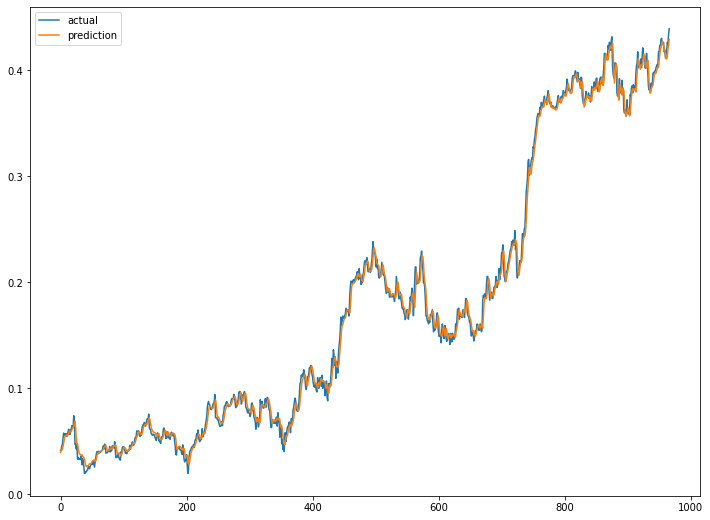

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [ ]:
pred = model.predict(test_X)

plt.figure()
plt.plot(test_y, color='red')
plt.plot(pred_y, color='blue')
plt.title('환율 예측')
plt.legend()
plt.show()

print("내일 환율은 1달러에:", currency.종가[len(currency.종가)-1] * pred_y[len(pred_y)-1] / dfy.종가[len(dfy.종가)-1], 'KRW')

NameError: ignored

### 결과

- 학습 후 도출된 결과를 보니 학습률이 굉장히 뛰어남.
- 그러나 미래 예측은 불가능하며 과거부터 현재까지의 예측만 가능한 모델이라는 것을 확인함

결론: LSTM을 이용한 모델은 학습률이 굉장히 뛰어나고 결과도 깔끔하게 나오나 본래 목적인 미래 예측이 불가능하므로 환율 예측에 부적합함

## RNN 모델 시도
https://wikidocs.net/173005

In [ ]:
def MinMaxScaler(data):
    """최솟값과 최댓값을 이용하여 0 ~ 1 값으로 변환"""
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # 0으로 나누기 에러가 발생하지 않도록 매우 작은 값(1e-7)을 더해서 나눔
    return numerator / (denominator + 1e-7)

In [ ]:
dfx = currency[['종가','오픈','고가','저가', '변동 %']]
dfx = MinMaxScaler(dfx)
dfy = dfx[['종가']]
dfx = dfx[['오픈','고가','저가']]
dfx

In [ ]:
X = dfx.values.tolist()
y = dfy.values.tolist()

In [ ]:
window_size = 10

data_X = []
data_y = []
for i in range(len(y) - window_size):
    _X = X[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y[i + window_size]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

In [ ]:
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
model = Sequential()
model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(10, 3)))
model.add(Dropout(0.1))
model.add(LSTM(units=20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_X, train_y, epochs=70, batch_size=30)
pred_y = model.predict(test_X)

In [ ]:
pred_y = model.predict(test_X)

plt.figure()
plt.plot(test_y, color='red')
plt.plot(pred_y, color='blue')
plt.title('환율 예측')
plt.legend()
plt.show()

print("내일 환율은 1달러에:", currency.종가[len(currency.종가)-1] * pred_y[len(pred_y)-1] / dfy.종가[len(dfy.종가)-1], 'KRW')

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(pred_y)

### 결과

결과를 확인해보니 중간에 같은 값이 연속으로 입력이 되있는 것을 확인함.

학습이 제대로 안된 것으로 추정됨.

결론: 중간에 같은 값이 연속으로 입력되는 오류를 해결하여 제대로 학습을 시키면 쓸만하겠지만 오류로 인해 아직은 아니다.

<b>2차 확인</b>

예측 데이터로 그린 그래프가 테스트 데이터로 그린 그래프와 거의 동일한 모습을 

보여준다. 

또한, 값도 정확하지는 않지만 제대로 제공해준다.

In [ ]:
da

## fbprofhet 모델 시도

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(x='날짜', y='종가', data=currency)
plt.show()               

NameError: ignored

<Figure size 1152x648 with 0 Axes>

In [ ]:
currency.index = currency.날짜

In [ ]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2022']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = currency.loc[(currency.index > time_steps[i][0]) & (currency.index < time_steps[i][1])]
    sns.lineplot(y=df['종가'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

In [ ]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [ ]:
currency['y'] = currency['종가']
currency['ds'] = currency.index

In [ ]:
m = Prophet()
m.fit(currency)

In [ ]:
future = m.make_future_dataframe(periods=30)
future.tail()

In [ ]:
forecast = m.predict(future)
forecast.tail()

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-40:-20]

In [ ]:
fig = m.plot(forecast)

In [ ]:
fig = plot_plotly(m, forecast)
fig

In [ ]:
plot_components_plotly(m, forecast)

In [ ]:
from prophet.plot import add_changepoints_to_plot

In [ ]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
m = Prophet(changepoint_prior_scale=0.8)
forecast = m.fit(currency).predict(future)
fig = m.plot(forecast)

NameError: ignored

In [ ]:
m = Prophet(changepoint_prior_scale=0.01)
forecast = m.fit(currency).predict(future)
fig = m.plot(forecast)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
my_date = str(input('예측할 날짜를 입력해주세요 >> '))

In [ ]:
f_pred = round(forecast[forecast['ds']==my_date]['yhat'].values[0], 2)
f_pred_h = round(forecast[forecast['ds']==my_date]['yhat_upper'].values[0], 2)
f_pred_l = round(forecast[forecast['ds']==my_date]['yhat_lower'].values[0], 2)
f_pred

In [ ]:
print('입력하신 날짜의 예측 환율은 :',f_pred,'입니다.')
print('입력하신 날짜의 예측 최대 환율은 :',f_pred_h,'입니다.')
print('입력하신 날짜의 예측 최소 환율은 :',f_pred_l,'입니다.')

### 결과

- 여태까지 사용했던 모듈 중에서 가장 정확도가 높다고 생각된다
- 하지만 정확한 수치를 보여주지 않고 그래프로만 예측을 해주기 때문에 살짝 아쉬움이 있다.

결론: 
- 여태까지 봤던 것들 중에서 가장 정확도가 높다고 생각되지만, 정확한 수치를 알려주지 않기 때문에 조금 더 고려해 볼 필요가 있다.

2차 시도:
- 정확한 수치를 표현하는데 성공했다.